<a href="https://colab.research.google.com/github/AliEbadi110/Natural-Language-Processing-Text-Classification-Sample-Projects/blob/main/NLP_Transformers_Text_Classification_Spam_Detection_SMS_Spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP - Transformers - Text Classification - Spam Detection - SMS Spam**

In [ ]:
!pip install transformers[torch]
!pip install datasets

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import TextClassificationPipeline

## 1. Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Datasets/smsspamcollection.tsv', sep='\t')
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [ ]:
df = df[['message', 'label']].copy()
df.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [ ]:
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

<Axes: xlabel='count', ylabel='label'>

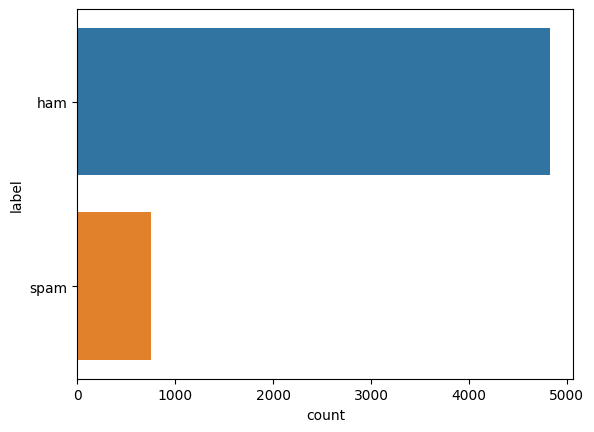

In [ ]:
sns.countplot(data=df, y='label')

In [ ]:
df.label.isnull().sum()

0

In [ ]:
target_map = {'spam': 1, 'ham': 0}
df['label'] = df['label'].map(target_map)

In [ ]:
df_train, df_val = train_test_split(df, test_size=0.2)

In [ ]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "val": Dataset.from_pandas(df_val)
    })

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['message', 'label', '__index_level_0__'],
        num_rows: 4457
    })
    val: Dataset({
        features: ['message', 'label', '__index_level_0__'],
        num_rows: 1115
    })
})

In [ ]:
dataset['train'][0]

{'message': 'Omg you can make a wedding chapel in frontierville? Why do they get all the good stuff?',
 'label': 0,
 '__index_level_0__': 4942}

## 2. Preprocessing

In [ ]:
model_name = 'bert-base-cased'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [ ]:
tokenizer(dataset['train'][0]['message'])

{'input_ids': [101, 152, 1306, 1403, 1128, 1169, 1294, 170, 4655, 6221, 1107, 13638, 2138, 136, 2009, 1202, 1152, 1243, 1155, 1103, 1363, 4333, 136, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
def tokenize_func(example):
  return tokenizer(example['message'], truncation=True)

In [ ]:
tokenized_dataset = dataset.map(tokenize_func, batched=True)
tokenized_dataset

Map:   0%|          | 0/4457 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['message', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4457
    })
    val: Dataset({
        features: ['message', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1115
    })
})

## 3. Train and Evaluate Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# For Multiclass Text Classification
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metric1 = load_metric('accuracy')
metric2 = load_metric('f1')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  accuracy = metric1.compute(predictions=predictions, references=labels)["accuracy"]
  f1 = metric2.compute(predictions=predictions, references=labels)["f1"]

  return {"accuracy": accuracy, "f1": f1}

<ipython-input-20-8a7b90626a6b>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric('accuracy')


In [ ]:
training_args = TrainingArguments('trainer_dir',
                                  per_device_train_batch_size=16,
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=5,
                                  load_best_model_at_end=True,
                                  logging_steps=200,
                                  )

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.069399,0.981166,0.934985
2,0.057300,0.077720,0.988341,0.955932
3,0.057300,0.084933,0.986547,0.952681
4,0.008400,0.051546,0.993722,0.977199
5,0.008400,0.054163,0.993722,0.977199


TrainOutput(global_step=1395, training_loss=0.024388644259463074, metrics={'train_runtime': 363.7591, 'train_samples_per_second': 61.263, 'train_steps_per_second': 3.835, 'total_flos': 829424199251700.0, 'train_loss': 0.024388644259463074, 'epoch': 5.0})

## 4. Evaluate

In [ ]:
trainer.evaluate()

{'eval_loss': 0.05154643952846527,
 'eval_accuracy': 0.9937219730941704,
 'eval_f1': 0.977198697068404,
 'eval_runtime': 6.0327,
 'eval_samples_per_second': 184.825,
 'eval_steps_per_second': 23.207,
 'epoch': 5.0}

In [ ]:
val_predictions = trainer.predict(tokenized_dataset['val'])

In [ ]:
val_preds = nn.functional.softmax(torch.Tensor(val_predictions.predictions), dim=-1)

In [ ]:
val_preds = torch.argmax(val_preds, axis=-1)

In [ ]:
print(classification_report(df_val['label'], val_preds.numpy()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       961
           1       0.98      0.97      0.98       154

    accuracy                           0.99      1115
   macro avg       0.99      0.99      0.99      1115
weighted avg       0.99      0.99      0.99      1115



In [ ]:
print(confusion_matrix(df_val['label'], val_preds.numpy()))

[[958   3]
 [  4 150]]


## 5. Predict

In [ ]:
# df_test = pd.read_csv('/content/drive/MyDrive/Colab Datasets/Hackathon/Problem 4/test.csv')
# df_test.head()

In [ ]:
# dataset_test = DatasetDict({
#     "test": Dataset.from_pandas(df_test)
#     })
# dataset_test

In [ ]:
# tokenized_datasets = dataset_test.map(tokenize_func, batched=True)
# tokenized_datasets

In [ ]:
# predictions = trainer.predict(dataset['test'])
# preds = nn.functional.softmax(torch.Tensor(predictions.predictions), dim=-1)
# preds = torch.argmax(preds, axis=-1)
# df = pd.DataFrame(preds.numpy(), columns=['label'])
# df.to_csv("output.csv")

## 6. Save and Load Model

In [ ]:
# model.save_pretrained('my_sentiment_bert_model')
# tokenizer.save_pretrained('my_sentiment_bert_model')

In [ ]:
# load_model = AutoModelForSequenceClassification.from_pretrained('my_sentiment_bert_model')
# load_tokenizer = AutoTokenizer.from_pretrained('my_sentiment_bert_model')

In [ ]:
# model = load_model
# tokenizer = load_tokenizer
# pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)
# pipe("hi. I'm on the way. where are you now?")

In [ ]:
# or

In [ ]:
# trainer.save_model('my_saved_model')
# clf = pipeline(
#     'text-classification',
#     model='my_saved_model', # model_path
#     device=0
# )
# clf('This movie is great')